# 05_05_check_asteroid_using_skybot

## 필요한 모듈

이 프로젝트를 위해서는 아래의 모듈이 필요하다. 

> numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ccdproc, version_information

### 모듈 설치

1. 콘솔 창에서 모듈을 설치할 때는 아래와 같은 형식으로 입력하면 된다.

>pip install module_name==version

>conda install module_name=version

2. 주피터 노트북(코랩 포함)에 설치 할 때는 아래의 셀을 실행해서 실행되지 않은 모듈을 설치할 수 있다. (pip 기준) 만약 아나콘다 환경을 사용한다면 7행을 콘다 설치 명령어에 맞게 수정하면 된다.

### 모듈 버전 확인

아래 셀을 실행하면 이 노트북을 실행한 파이썬 및 관련 모듈의 버전을 확인할 수 있다.

In [2]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ysfitsutilpy, ysphotutilpy, ccdproc, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        print(f"**** module {pkg} is being installed")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
    else: 
        print(f"**** module {pkg} is installed")

%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module astroquery is installed
**** module photutils is installed
**** module ysfitsutilpy is installed
**** module ysphotutilpy is installed
**** module ccdproc is installed
**** module version_information is installed
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2023-11-26 17:01:00 (KST = GMT+0900) 
0 Python     3.11.5 64bit [GCC 11.2.0]
1 IPython    8.15.0
2 OS         Linux 5.15.0 89 generic x86_64 with glibc2.31
3 numpy      1.26.0
4 pandas     2.1.1
5 matplotlib 3.8.0
6 scipy      1.11.3
7 astropy    5.3.4
8 astroquery 0.4.6
9 photutils  1.6.0
10 ysfitsutilpy 0.2
11 ysphotutilpy (numpy 1.22.0 (/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages), Requirement.parse('numpy>=1.23.2; python_version == "3.

### import modules

In [3]:
from glob import glob
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ccdproc import combine, ccd_process, CCDData

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.time import Time
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from astroquery.jplhorizons import Horizons
from astroquery.imcce import Skybot

import ysfitsutilpy as yfu

import _astro_utilities
import _Python_utilities

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clip, sigma_clipped_stats
from photutils.centroids import centroid_com

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn

plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
#%%
#######################################################
# read all files in base directory for processing
BASEDIR = Path("/mnt/Rdata/ASTRO_data") 
DOINGDIR = Path(BASEDIR/ "asteroid" / "RiLA600_STX-16803_-_1bin")
DOINGDIR = Path(BASEDIR/ "asteroid" / "GSON300_STF-8300M_-_1bin")

DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(DOINGDIR))
#print ("DOINGDIRs: ", format(DOINGDIRs))
print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))
#######################################################

len(DOINGDIRs):  71


In [5]:
def znorm(image, **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs))

def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image, **kwargs), origin='lower')

#####################################################################
# Our object (will be queried to JPL HORIZONS)
#OBJID = '2159' # 

# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
Suwon =  EarthLocation(lon=127.005 * u.deg, 
                                 lat=37.308889 * u.deg, 
                                 height=101 * u.m)
observatory_code = "P64"

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

Mag_UP = 17
#######################################################

In [6]:
for DOINGDIR in DOINGDIRs[:1] :
    DOINGDIR = Path(DOINGDIR)
    print("DOINGDIR", DOINGDIR)

    ASTRESULTDIR = DOINGDIR / _astro_utilities.Asteroid_result_dir
    DOINGDIR = DOINGDIR / _astro_utilities.reduced_nightsky_dir
    
    if not ASTRESULTDIR.exists():
        os.makedirs("{}".format(str(ASTRESULTDIR)))
        print("{} is created...".format(str(ASTRESULTDIR)))
    
    fits_in_dir = sorted(list(DOINGDIR.glob('*.fit*')))
    #print("fits_in_dir", fits_in_dir)
    print("len(fits_in_dir)", len(fits_in_dir))

    if len(fits_in_dir) == 0 :
        print(f"There is no fits fils in {DOINGDIR}")
        pass
    else : 
        print(f"Starting: {str(DOINGDIR.parts[-1])}")

        summary = yfu.make_summary(DOINGDIR/"*.fit*")
        print("len(summary):", len(summary))
        #print("summary:", summary)
        #print(summary["file"][0])
        df_light = summary.loc[summary["IMAGETYP"] == "LIGHT"].copy()
        df_light = df_light.reset_index(drop=True)
        #print("df_light:\n{}".format(df_light))

DOINGDIR /mnt/Rdata/ASTRO_data/asteroid/GSON300_STF-8300M_-_1bin/120LACHESIS_LIGHT_-_2023-10-09_-_GSON300_STF-8300M_-_1bin
len(fits_in_dir) 50
Starting: REDUC_nightsky
All 122 keywords (guessed from /mnt/Rdata/ASTRO_data/asteroid/GSON300_STF-8300M_-_1bin/120LACHESIS_LIGHT_-_2023-10-09_-_GSON300_STF-8300M_-_1bin/REDUC_nightsky/120LACHESIS_LIGHT_B_2023-10-09-17-22-53_60sec_GSON300_STF-8300M_0c_1bin.fits) will be loaded.


/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysfitsutilpy/filemgmt.py:298: UserWarning: Key _TYPE1 not found for /mnt/Rdata/ASTRO_data/asteroid/GSON300_STF-8300M_-_1bin/120LACHESIS_LIGHT_-_2023-10-09_-_GSON300_STF-8300M_-_1bin/REDUC_nightsky/120LACHESIS_LIGHT_B_2023-10-09-17-59-47_60sec_GSON300_STF-8300M_0c_1bin.fits, filling with None.
  warn(str_keyerror_fill.format(k, str(item)))
/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysfitsutilpy/filemgmt.py:298: UserWarning: Key _TYPE2 not found for /mnt/Rdata/ASTRO_data/asteroid/GSON300_STF-8300M_-_1bin/120LACHESIS_LIGHT_-_2023-10-09_-_GSON300_STF-8300M_-_1bin/REDUC_nightsky/120LACHESIS_LIGHT_B_2023-10-09-17-59-47_60sec_GSON300_STF-8300M_0c_1bin.fits, filling with None.
  warn(str_keyerror_fill.format(k, str(item)))
/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysfitsutilpy/filemgmt.py:298: UserWarning: Key _UNIT1 not found for /mnt/Rdata/ASTRO_data/

len(summary): 50


/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysfitsutilpy/filemgmt.py:298: UserWarning: Key _TYPE1 not found for /mnt/Rdata/ASTRO_data/asteroid/GSON300_STF-8300M_-_1bin/120LACHESIS_LIGHT_-_2023-10-09_-_GSON300_STF-8300M_-_1bin/REDUC_nightsky/120LACHESIS_LIGHT_R_2023-10-09-20-11-28_60sec_GSON300_STF-8300M_0c_1bin.fits, filling with None.
  warn(str_keyerror_fill.format(k, str(item)))
/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysfitsutilpy/filemgmt.py:298: UserWarning: Key _TYPE2 not found for /mnt/Rdata/ASTRO_data/asteroid/GSON300_STF-8300M_-_1bin/120LACHESIS_LIGHT_-_2023-10-09_-_GSON300_STF-8300M_-_1bin/REDUC_nightsky/120LACHESIS_LIGHT_R_2023-10-09-20-11-28_60sec_GSON300_STF-8300M_0c_1bin.fits, filling with None.
  warn(str_keyerror_fill.format(k, str(item)))
/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysfitsutilpy/filemgmt.py:298: UserWarning: Key _UNIT1 not found for /mnt/Rdata/ASTRO_data/

In [7]:
for _, row  in df_light.iterrows():
    fpath = Path(row["file"])
    hdul = fits.open(fpath)

    SOLVE, ASTAP, LOCAL = _astro_utilities.checkPSolve(fpath)
    print(SOLVE, ASTAP, LOCAL)
    
    if SOLVE :
        wcs = WCS(hdul[0].header)
        # It is used as a rough estimate, so no need to be accurate:
        #PIX2ARCSEC = 0.62*u.arcsec
        if 'PIXSCALE' in hdul[0].header:
            PIX2ARCSEC = hdul[0].header['PIXSCALE']
        else : 
            PIX2ARCSEC = _astro_utilities.calPixScale(hdul[0].header['FOCALLEN'], 
                                            hdul[0].header['XPIXSZ'],
                                            hdul[0].header['XBINNING'])
        
        # D.2. Find the observation time and exposure time to set the obs time
        t_start = Time(hdul[0].header['DATE-OBS'], format='isot')
        t_expos = hdul[0].header['EXPTIME'] * u.s
        t_middle = t_start + t_expos / 2 # start time + 0.5 * exposure time
        #print(f"t_start: {t_start}, t_expos: {t_expos}, t_middle: {t_middle}")
        
        cent_coord = yfu.center_radec(ccd_or_header=hdul[0].header, 
                                      center_of_image=True)
        results_ast = Skybot.cone_search(cent_coord, 
                                         30*u.arcmin, 
                                         t_middle)
        #print(results_ast.pprint(max_width=80) )

        offset_RA = (cent_coord.ra.to(u.deg) - hdul[0].header['RA']*u.deg).to(u.arcmin)
        offset_DEC = (cent_coord.dec.to(u.deg) - hdul[0].header['DEC']*u.deg).to(u.arcmin) 
        altaz = AltAz(obstime=t_middle, location=Suwon)   
        cent_aa = cent_coord.transform_to(altaz)
        offset_AZ = (cent_aa.az.to(u.deg) - hdul[0].header['CENTAZ']*u.deg).to(u.arcmin)
        offset_ALT = (cent_aa.alt.to(u.deg) - hdul[0].header['CENTALT']*u.deg).to(u.arcmin)

        df_ast = results_ast.to_pandas()
        df_ast

Set MJD-AVG to 60226.724580 from DATE-AVG'. [astropy.wcs.wcs]


True True True


In [ ]:
df_ast

df_targ = df_ast[df_ast['V'] < Mag_UP]
df_targ = df_targ.sort_values(by=['V'])
df_targ = df_targ.reset_index(drop=True)
df_targ

,Number,Name,RA,DEC,Type,V,posunc,centerdist,RA_rate,DEC_rate,...,heliodist,alpha,elong,x,y,z,vx,vy,vz,epoch
0,127,Johanna,29.779466,14.373827,MB>Middle,12.4,0.016,1448.332,-28.678,-3.914,...,2.716654,7.9,157.75,2.113807,1.560337,0.737063,-0.00708,0.006363,0.00436,2460260.0


In [ ]:
if df_targ.empty:
    pass
else:
    df_targ_eph = pd.DataFrame()

    for i, row in df_targ.iterrows() :
        #print("type(row)", type(row))
        #Query the ephemerides of this target! 
        obj = Horizons(id=row['Number'], 
                       location=observatory_code, 
                       epochs=t_middle.jd)
        obj_ephem = obj.ephemerides()
        #print(obj_ephem)
        df_eph = obj_ephem.to_pandas()
        df_targ_eph = pd.concat([df_targ_eph, df_eph], axis = 0)
    #print(df_targ_eph)
    df_targ_eph = df_targ_eph.reset_index(drop=True)
    df_targ_eph = pd.concat([df_targ, df_targ_eph], axis = 1)
    print("df_targ_eph :", df_targ_eph)        

df_targ_eph :    Number     Name         RA        DEC       Type     V  posunc  centerdist  \
0     127  Johanna  29.779466  14.373827  MB>Middle  12.4   0.016    1448.332   

   RA_rate  DEC_rate  ...  r_3sigma  r_rate_3sigma  SBand_3sigma  \
0  -28.678    -3.914  ...   16.1267       0.000002          0.07   

   XBand_3sigma  DoppDelay_3sigma  true_anom  hour_angle  alpha_true   PABLon  \
0          0.26          0.000108   277.4457    6.223404      7.8967  36.6523   

   PABLat  
0  1.7282  

[1 rows x 104 columns]


In [ ]:
#dir(obj_ephem)

In [ ]:
duplicated_columns_list = []
list_of_all_columns = list(df_targ_eph.columns)
for column in list_of_all_columns:
    if list_of_all_columns.count(column) > 1 and not column in duplicated_columns_list:
        duplicated_columns_list.append(column)
duplicated_columns_list

for column in duplicated_columns_list:
    list_of_all_columns[list_of_all_columns.index(column)] = column
    list_of_all_columns[list_of_all_columns.index(column)] = column + '_1'

df_targ_eph.columns = list_of_all_columns
#print(df_targ_eph.columns)
df_targ_eph.to_csv(f"{ASTRESULTDIR/fpath.stem}_AST_Mag{Mag_UP}.csv")
df_targ_eph.dropna(subset = ['RA', 'DEC', 'V', 'RA_1', 'DEC_1', 'V_1'], inplace=True)
df_targ_eph[['RA', 'DEC', 'V', 'RA_1', 'DEC_1', 'V_1']]

,RA,DEC,V,RA_1,DEC_1,V_1
0,29.7785,14.37302,12.582,29.779466,14.373827,12.4


In [ ]:
# RADEC_targ = np.array([df_targ_eph['RA'], df_targ_eph["DEC"]]).T
# RADEC_targ
# pos_targ_init = SkyCoord(RADEC_targ, 
#         **SKYC_KW).to_pixel(wcs, origin=1, mode='wcs')
# print("pos_targ_init:", pos_targ_init)

In [ ]:
pos_targ_init = SkyCoord(df_targ_eph['RA']*u.deg, df_targ_eph["DEC"]*u.deg, 
                        **SKYC_KW).to_pixel(wcs, origin=0, mode='wcs')
pos_targ_init = np.array(pos_targ_init).T
print("pos_targ_init:", pos_targ_init)

pos_targ_init: [[1116.2837292  2743.75040242]]


In [ ]:
hdul[0].header['CCDNAME'] 

'STF-8300M'

In [ ]:
if hdul[0].header['CCDNAME'] == 'STF-8300M' :
     val_figsize = (13, 5.2)
     val_fraction = 0.035
if hdul[0].header['CCDNAME'] == 'STX-16803' :
     val_figsize=(12, 6.2)
     val_fraction = 0.0455

fig_set = plt.figure(figsize=val_figsize)
ax1 = plt.subplot2grid((1,2), (0,0),
                    fig=fig_set)
im1 = zimshow(ax1, hdul[0].data, )
ax1.set_title('Pixel coordinate system', fontsize=9)
ax1.tick_params(labelsize=8)
plt.colorbar(im1, ax = ax1, fraction=val_fraction, pad=0.04)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)
im2 = zimshow(ax2, hdul[0].data, )
ax2.set_title('World coordinate system', fontsize=9)
ax2.coords.grid(True, color='white', ls=':')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
ax2.coords['dec'].set_ticklabel_position('bl')
ax2.coords['ra'].set_major_formatter('hh:mm')
ax2.coords['dec'].set_major_formatter('dd:mm')
ax2.coords['ra'].display_minor_ticks(True)
ax2.coords['dec'].display_minor_ticks(True)
ax2.coords['ra'].set_minor_frequency(2)
ax2.coords['dec'].set_minor_frequency(2)
ax2.tick_params(labelsize=8)

if df_targ.empty:
    pass
else:
    targ_ap = CAp(pos_targ_init,
            r=R_AP, 
            )
    targ_an = CAn(pos_targ_init,
            r_in=R_IN,
            r_out=R_OUT)
    
    #targ_ap.plot(ax1, color="r")
    targ_an.plot(ax1, color="r")
    #targ_ap.plot(ax2, color="r")
    targ_an.plot(ax2, color="r")

    ax1.annotate(f"{pos_targ_init}",
            xy=(0, 0), xytext=(0, -0.1),
            xycoords='axes fraction',
            va='top', ha='left',
            fontsize=7)

    ax2.annotate(f"{df_targ_eph[['Number', 'RA', 'DEC', 'V']]}",
            xy=(0, 0), xytext=(0, -0.1),
            xycoords='axes fraction',
            va='top', ha='left',
            fontsize = 6)
plt.colorbar(im2, ax = ax2, fraction=val_fraction, pad=0.04)
plt.suptitle(f"fname: {fpath.name}")

ax2.annotate(f"image center (RA, DEC): ({cent_coord.ra:.03f}, {cent_coord.dec:.03f})\ntelescope center (RA, DEC): ({hdul[0].header['RA']*u.deg:.03f}, {hdul[0].header['DEC']*u.deg:.03f})\noffset (RA, DEC): ({offset_RA:.03f}, {offset_DEC:.03f})\noffset (AZ, ALT): ({offset_AZ:.03f}, {offset_ALT:.03f})",
            xy=(0, 0), xytext=(0.6, -0.1),
            xycoords='axes fraction',
            va='top', ha='left',
            fontsize = 6)
plt.tight_layout()
plt.savefig(f"{ASTRESULTDIR/fpath.stem}_AST_Mag{Mag_UP}.png")
plt.show()
#plt.close()

Err : Arrays do not overlap.


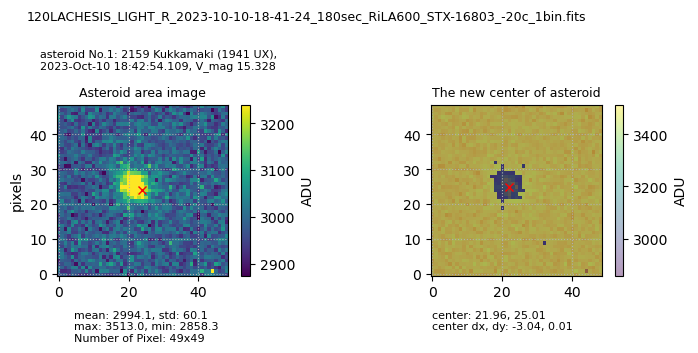

In [ ]:
if df_targ.empty:
    pass
else:
    cutsizes = 49
    for i, row in df_targ_eph.iterrows():
        try : 
            #1. cut asteroia area
            #print(i)
            cut_hdu = Cutout2D(
                        data = hdul[0].data,
                        position = (pos_targ_init[i]),
                        size=(cutsizes, cutsizes) #cut ccd
                        )
            avg, med, std = sigma_clipped_stats(cut_hdu.data)  # by default, 3-sigma 5-iteration.

            fig_set = plt.figure(figsize=(8, 5.5))
            
            ax11 = plt.subplot2grid((2, 2), (0,0),
                        fig=fig_set)
            im11 = zimshow(ax11, cut_hdu.data)
            ax11.plot(round(cutsizes/2), round(cutsizes/2), 'rx')
            ax11.set_ylabel('pixels')
            ax11.grid(ls=':')
            ax11.set_title(f'Asteroid area image', fontsize=9)
            ax11.annotate(   f"mean: {np.mean(cut_hdu.data):.01f}, std: {np.std(cut_hdu.data):.01f} \nmax: {np.max(cut_hdu.data):.01f}, min: {np.min(cut_hdu.data):.01f} \nNumber of Pixel: {np.shape(cut_hdu.data)[0]:.0f}x{np.shape(cut_hdu.data)[1]:.0f}",
                xy=(0, 0), xytext=(0.1, -0.20),
                xycoords='axes fraction',
                va='top', ha='left',
                fontsize=8)
            plt.colorbar(im11,
                        ax=ax11,
                        label="ADU",
                        fraction=0.0455, pad=0.04)
            #print("Image size is: ", cut_hdu.data.shape)

            #2. Get center dx, dy
            thresh_3sig = med + 3 * std
            mask_3sig = (cut_hdu.data < thresh_3sig)
            center = centroid_com(
                        data = cut_hdu.data,
                        mask = mask_3sig
                        )

            centerdx = center[0] - ((cutsizes+1)/2)
            centerdy = center[1] - ((cutsizes+1)/2)

            # print("type(center):", type(center))
            # print("center:", center)
            # print("center dx, dy:", centerdx, centerdy)

            ax12 = plt.subplot2grid((2,2), (0,1),
                        fig=fig_set)
            ax12.grid(ls=':')
            ax12.set_title(f'The new center of asteroid', fontsize=9)
            im12 = ax12.imshow(mask_3sig.astype(int),
                origin="lower")
            im12 = ax12.imshow(cut_hdu.data,
                    alpha=0.4,
                    origin="lower")
            ax12.plot(*center, 'rx')
            ax12.annotate(f"center: {center[0]:.02f}, {center[1]:.02f}\ncenter dx, dy: {centerdx:.02f}, {centerdy:.02f}",
                    xy=(0, 0), xytext=(0.01, -0.20),
                    xycoords='axes fraction',
                    va='top', ha='left',
                    fontsize=8)
            
            ax11.annotate(f"asteroid No.{i}: {row['targetname']}, \n{row['datetime_str']}, V_mag {row['V']}",
                    xy=(1, 0), xytext=(-0.1, 1.33),
                    xycoords='axes fraction',
                    va='top', ha='left',
                    fontsize=8)
            
            plt.colorbar(im12,
                        ax=ax12,
                        label="ADU",
                        fraction=0.0455, pad=0.04)
            plt.suptitle(f"{fpath.name}", 
                        fontsize=9)
            
            plt.tight_layout()
            plt.savefig(f"{ASTRESULTDIR/fpath.stem}_AST_Mag{Mag_UP}_{i:02d}.png")
            plt.show()
            #plt.close()

        except Exception as err: 
            print("Err :", err)
            continue